## Importing Libraries

In [4]:
!pip install neattext

In [5]:
!pip install scikit-multilearn 

In [6]:
!pip install xgboost

In [7]:
import pandas as pd 
import numpy as np 
import re
import string

In [8]:
# text processing libraries
import re
import string
from nltk.corpus import stopwords
# from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer



In [9]:
# plot libraries
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline 
sns.set(color_codes=True)

In [10]:
# model related libraries
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# from sklearn.model_selection import train_test_split

In [11]:
from sklearn.ensemble import GradientBoostingClassifier
import xgboost as xgb

In [12]:
# metrics
from sklearn.metrics import classification_report, multilabel_confusion_matrix, roc_auc_score
from sklearn.metrics import accuracy_score, hamming_loss

In [13]:
# others
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## 1. Data Exploration

First let's look at how the data is organized. 

In [14]:
data = pd.read_csv('data/data.csv')
data.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


#### Then lets make some visualization about the dataset for furhter understanding.

Strating from a simple bar chart that shows the number of comments for each category. 

Text(0.5, 0, '# of categories')

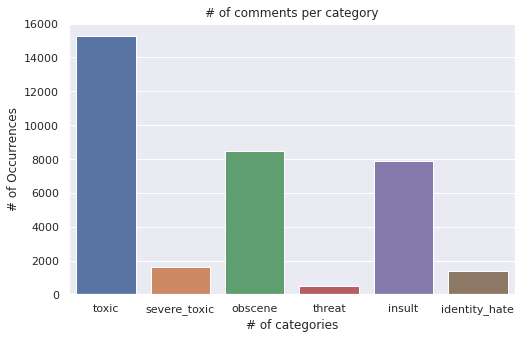

In [15]:
labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 
      'insult', 'identity_hate']
labels_data = data[labels]
label_count = labels_data.sum()
plt.figure(figsize=(8,5))
ax = sns.barplot(label_count.index, label_count.values)
plt.title("# of comments per category")
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('# of categories', fontsize=12)

In [16]:
# test_data = pd.read_csv('data/test.csv')
# test_labels = pd.read_csv('data/test_labels.csv')

Since the categories are not mutally exclusive, let's see how many categories each comment coantains. 

Text(0.5, 0, '# of categories')

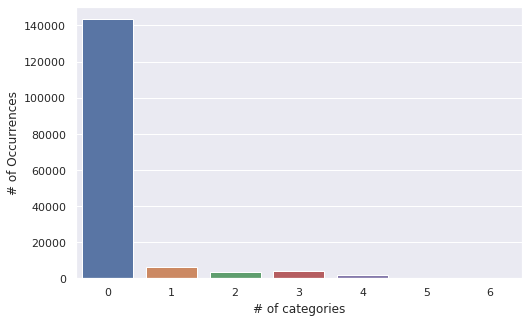

In [17]:
rowsums = data.iloc[:,2:].sum(axis=1)
x=rowsums.value_counts()#plot
plt.figure(figsize=(8,5))
ax = sns.barplot(x.index, x.values)
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('# of categories', fontsize=12)

We can see that the dataset is biased towards non-categoized comments. 



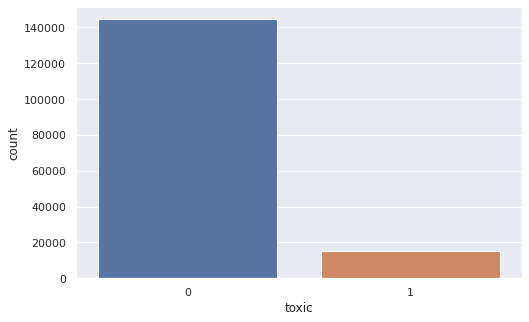

In [18]:
plt.figure(figsize=(8,5))
g = sns.countplot(data['toxic'])
plt.show()

In [19]:
def plot_data(): 
    barWidth = 0.35
    plt.figure(figsize=(8,5))
    bars1 = [sum(data['toxic'] == 1), sum(data['severe_toxic'] == 1), sum(data['obscene'] == 1), sum(data['threat'] == 1),
             sum(data['insult'] == 1), sum(data['identity_hate'] == 1)]
    bars2 = [sum(data['toxic'] == 0), sum(data['severe_toxic'] == 0), sum(data['obscene'] == 0), sum(data['threat'] == 0),
             sum(data['insult'] == 0), sum(data['identity_hate'] == 0)]

    r1 = np.arange(len(bars1))
    r2 = [x + barWidth for x in r1]

    plt.bar(r1, bars1, color='steelblue', width=barWidth, label='classified')
    plt.bar(r2, bars2, color='lightsteelblue', width=barWidth, label='not_classified')

    plt.xlabel('categories')
    plt.ylabel('# of comments')
    plt.xticks([r + barWidth for r in range(len(bars1))], labels)

    plt.legend()
    plt.show()
    pass 

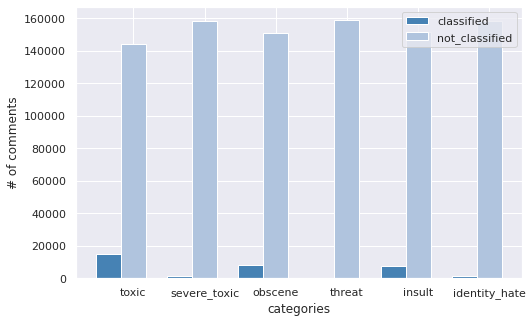

In [20]:
plot_data()

The plot above shows that there is an imbalance dataset. So, to address this issue we will need to drop data that does not fall into any category

In [21]:
data.drop('id', axis=1, inplace=True)
data_drop = data[
    (data['toxic'] == 0) & 
    (data['severe_toxic'] == 0) & 
    (data['obscene'] == 0) & 
    (data['threat'] == 0) & 
    (data['insult'] == 0) & 
    (data['identity_hate'] == 0)
         ].head(int(len(data)*(60/100)))

data.drop(data_drop.index, axis=0, inplace=True)
data.reset_index(drop=True, inplace=True)

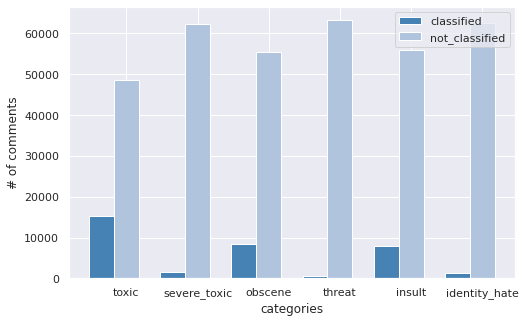

In [22]:
plot_data()

The data does not seem to perform well, when we tried to remove some entris.

So, we need to re-read the origian dataset. 

In [44]:
data = pd.read_csv('data/data.csv')

## 2. Data Preparation

### Data Preprocessing

For data cleaning we need to define a function to: 
  * `Remove HTML tags`
  * `Convert all letters into lowerecase`
  * `Remove all non-alphapet characters`

In [40]:
import neattext.functions as nfx
import re
from bs4 import BeautifulSoup
# from nltk.stem.porter import *
from nltk.stem import SnowballStemmer
import nltk
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def preprocess_text(data):
    stemmer = SnowballStemmer(language='english')
    text = BeautifulSoup(data, "html.parser").get_text() # Remove HTML tags
    text = re.sub(r"[^a-zA-Z]", " ", text.lower()) # Convert to lower case
    words = text.split()
    words = [stemmer.stem(w) for w in words if w not in stopwords.words("english")] # Remove stopwords
#     words = [stemmer.stem(w) for w in words] # stem
    words = ' '.join(words)

    return words

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/ec2-user/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


First, let's take a look at a sample origianl comment.

In [47]:
data['comment_text'][0]

"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27"

Then let's see the same comment after cleaning. 

In [41]:
preprocess_text(data['comment_text'][0])

'explan edit made usernam hardcor metallica fan revert vandal closur gas vote new york doll fac pleas remov templat talk page sinc retir'

Processing all comments in the training set. 

In [48]:
data['comment_text'] = data['comment_text'].apply(preprocess_text)
# data['comment_text'] = [preprocess_text(comment) for comment in data['comment_text']]

/home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/bs4/__init__.py:424: MarkupResemblesLocatorWarning: "http://en.wikipedia.org/wiki/Wikipedia_talk:No_original_research/archive15#YouTube_art_as_primary_source" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  MarkupResemblesLocatorWarning
/home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/bs4/__init__.py:424: MarkupResemblesLocatorWarning: "http://finance.yahoo.com/news/7-fascinating-nuggets-another-bewildering-150348488.html" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  MarkupResemblesLocatorWarning
/home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/bs4/__init__.py:424: MarkupResemblesLocatorWarning: "http:

In [50]:
data.drop('id', inplace=True, axis=1)
data.reset_index(drop=True, inplace=True)
data.to_csv('data/train-processed.csv')

In [ ]:
# data.to_csv('model_data/train.csv', index=False, header=False)

### Preparing training and testing sets 


The dataset obtained has already provided us with training a testing sets. 

The data above will be our training data, and the upcoming cells will read the testing data and prepare it for the model. 

In [53]:
# Read test.csv and test_labels files

train = data.copy()
data = pd.read_csv('data/test.csv')
data_labels = pd.read_csv('data/test_labels.csv')

In [54]:
data

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.
...,...,...
153159,fffcd0960ee309b5,". \n i totally agree, this stuff is nothing bu..."
153160,fffd7a9a6eb32c16,== Throw from out field to home plate. == \n\n...
153161,fffda9e8d6fafa9e,""" \n\n == Okinotorishima categories == \n\n I ..."
153162,fffe8f1340a79fc2,""" \n\n == """"One of the founding nations of the..."


In [55]:
data_labels

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,-1,-1,-1,-1,-1,-1
1,0000247867823ef7,-1,-1,-1,-1,-1,-1
2,00013b17ad220c46,-1,-1,-1,-1,-1,-1
3,00017563c3f7919a,-1,-1,-1,-1,-1,-1
4,00017695ad8997eb,-1,-1,-1,-1,-1,-1
...,...,...,...,...,...,...,...
153159,fffcd0960ee309b5,-1,-1,-1,-1,-1,-1
153160,fffd7a9a6eb32c16,-1,-1,-1,-1,-1,-1
153161,fffda9e8d6fafa9e,-1,-1,-1,-1,-1,-1
153162,fffe8f1340a79fc2,-1,-1,-1,-1,-1,-1


We can see that the testing set is devided into two sets, one conatins the comments ` X ` and the other contains the labels ` y `. Where they are linked via the comment id number. 

We can also notice that some comments conatain label values of  ` -1 `, which according to the dataset source indicates an ingonre signal that does not mean anything. 
So we will drop rows that conatians -1 labels in both data and data_labels sets. 

In [56]:
drop_index = data_labels[
    (data_labels['toxic'] == -1) | 
    (data_labels['severe_toxic'] == -1) | 
    (data_labels['obscene'] == -1) | 
    (data_labels['threat'] == -1) | 
    (data_labels['insult'] == -1) | 
    (data_labels['identity_hate'] == -1)
]['id']

# data.drop(drop_index.id, axis=0, inplace=True)
# data_labels.drop(drop_index.id, axis=0, inplace=True)
# new_df = sales[~sales.CustomerID.isin(badcu)]
data = data[~data.id.isin(drop_index)]
data_labels = data_labels[~data_labels.id.isin(drop_index)]

In [57]:
data

,id,comment_text
5,0001ea8717f6de06,Thank you for understanding. I think very high...
7,000247e83dcc1211,:Dear god this site is horrible.
11,0002f87b16116a7f,"""::: Somebody will invariably try to add Relig..."
13,0003e1cccfd5a40a,""" \n\n It says it right there that it IS a typ..."
14,00059ace3e3e9a53,""" \n\n == Before adding a new product to the l..."
...,...,...
153150,fff8f64043129fa2,":Jerome, I see you never got around to this…! ..."
153151,fff9d70fe0722906,==Lucky bastard== \n http://wikimediafoundatio...
153154,fffa8a11c4378854,==shame on you all!!!== \n\n You want to speak...
153155,fffac2a094c8e0e2,MEL GIBSON IS A NAZI BITCH WHO MAKES SHITTY MO...


In [58]:
data_labels

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
5,0001ea8717f6de06,0,0,0,0,0,0
7,000247e83dcc1211,0,0,0,0,0,0
11,0002f87b16116a7f,0,0,0,0,0,0
13,0003e1cccfd5a40a,0,0,0,0,0,0
14,00059ace3e3e9a53,0,0,0,0,0,0
...,...,...,...,...,...,...,...
153150,fff8f64043129fa2,0,0,0,0,0,0
153151,fff9d70fe0722906,0,0,0,0,0,0
153154,fffa8a11c4378854,0,0,0,0,0,0
153155,fffac2a094c8e0e2,1,0,1,0,1,0


`About 70000 rows have been dropped`. 

In [ ]:
# drop_index = data_labels[
#     (data_labels['toxic'] == 0) & 
#     (data_labels['severe_toxic'] == 0) & 
#     (data_labels['obscene'] == 0) & 
#     (data_labels['threat'] == 0) & 
#     (data_labels['insult'] == 0) & 
#     (data_labels['identity_hate'] == 0)
#            ].index
# data = data[~data.index.isin(drop_index)]
# data_labels = data_labels[~data_labels.index.isin(drop_index)]

In [ ]:
# data

In [ ]:
# data_labels

Since id column is used only for administrative purposees, we can drop it. 

In [59]:
data.drop('id', axis=1, inplace=True)
data_labels.drop('id', axis=1, inplace=True)

/home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [60]:
# processing testing set comments. 
data['comment_text'] = data['comment_text'].apply(preprocess_text)

/home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/bs4/__init__.py:424: MarkupResemblesLocatorWarning: "http://en.wikipedia.org/wiki/Half-Life_%28series%29" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  MarkupResemblesLocatorWarning
/home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/bs4/__init__.py:424: MarkupResemblesLocatorWarning: "http://es.wikipedia.org/wiki/Usuario_Discusi%C3%B3n:Sarah_W." looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  MarkupResemblesLocatorWarning
/home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/bs4/__init__.py:424: MarkupResemblesLocatorWarning: "http://en.wikipedia.org/wiki/Rayleigh%E2%80%93B%C3%A9nard_convection" looks like a U

In [61]:
data

,comment_text
5,thank understand think high would revert witho...
7,dear god site horribl
11,somebodi invari tri add religion realli mean w...
13,say right type type institut need case three l...
14,ad new product list make sure relev ad new pro...
...,...
153150,jerom see never got around surpris look exampl...
153151,lucki bastard http wikimediafound org wiki pre...
153154,shame want speak gay romanian
153155,mel gibson nazi bitch make shitti movi much bu...


In [62]:
data.reset_index(drop=True, inplace=True)
data_labels.reset_index(drop=True, inplace=True)

In [63]:
data.to_csv('data/test-processed.csv')

## 3. Modeling

Since we have a huge set of data, and extracting text_features using TfidfVectorizer that will be fed to the model will require a huge amount of memory.

We will use sklearn's `Pipline` to extract features from comments and train the model through piplining over each row, to save space. 

To do that we will define a function that will generate a pipline with the same vectorizer properties for differernt classifiers. 

In [64]:
def define_model(Classifier):
    model = Pipeline([
                    ('tfidf', TfidfVectorizer(
                        strip_accents='unicode',     
                        analyzer='word',            
                        token_pattern=r'\w{1,}',    
                        ngram_range=(1, 3),         
                        stop_words='english',
                        sublinear_tf=True)
                    ),
                    ('clf', Classifier)
                ])
    return model
    pass

In [65]:
X_test = data['comment_text']
y_test = data_labels
X_train = train['comment_text']
y_train = train.drop('comment_text', axis=1)

In [68]:
def train_and_test(x_train, y_train, x_test, y_test, model, labels):
#     predecition_df = pd.DataFrame()
#     for category in labels:
#         print('... Processing {}'.format(category))
#         # train the model using X_dtm & y
#         model.fit(x_train, y_train[category])
#         # compute the testing accuracy
#         prediction = model.predict(x_test)
# #         print('Test accuracy is {}'.format(accuracy_score(y_test[category], prediction)))
# #         print('Test accuracy is {}'.format(hamming_loss(y_test[category], prediction)))
#         predecition_df[category] = prediction
    model.fit(x_train, y_train)
    prediction = model.predict(x_test)
    return prediction
    pass



#### We will use `OneVsRestClassifier` for each of the following models


### MultinomialNB

In [69]:
model = define_model(OneVsRestClassifier(MultinomialNB(
                    fit_prior=True, class_prior=None)))
MNB_pred = train_and_test(X_train, y_train, X_test, y_test, model, labels)

In [70]:
confusion_matrix = multilabel_confusion_matrix(y_test, MNB_pred)
confusion_matrix

array([[[57876,    12],
        [ 5634,   456]],

       [[63611,     0],
        [  367,     0]],

       [[60285,     2],
        [ 3544,   147]],

       [[63767,     0],
        [  211,     0]],

       [[60551,     0],
        [ 3412,    15]],

       [[63266,     0],
        [  712,     0]]])

In [71]:
print(classification_report(
    y_test,
    MNB_pred,
    output_dict=False,
    target_names=labels
))

               precision    recall  f1-score   support

        toxic       0.97      0.07      0.14      6090
 severe_toxic       0.00      0.00      0.00       367
      obscene       0.99      0.04      0.08      3691
       threat       0.00      0.00      0.00       211
       insult       1.00      0.00      0.01      3427
identity_hate       0.00      0.00      0.00       712

    micro avg       0.98      0.04      0.08     14498
    macro avg       0.49      0.02      0.04     14498
 weighted avg       0.90      0.04      0.08     14498
  samples avg       0.01      0.00      0.00     14498



/home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, l

we can see from the confusion_matrix that MultinomialNB did not perform well in predicting severe_toxic, threat, and identity_hate. 

### LogisticRegression

In [72]:
model = define_model(OneVsRestClassifier(LogisticRegression(C = 10, penalty='l2', solver = 'liblinear', random_state=100)))
LR_pred = train_and_test(X_train, y_train, X_test, y_test, model, labels)

In [73]:
confusion_matrix = multilabel_confusion_matrix(y_test, LR_pred)
confusion_matrix

array([[[53830,  4058],
        [ 1024,  5066]],

       [[63111,   500],
        [  180,   187]],

       [[58523,  1764],
        [  832,  2859]],

       [[63654,   113],
        [  134,    77]],

       [[58770,  1781],
        [  963,  2464]],

       [[62957,   309],
        [  335,   377]]])

In [74]:
print(classification_report(
    y_test,
    LR_pred,
    output_dict=False,
    target_names=labels
))

               precision    recall  f1-score   support

        toxic       0.56      0.83      0.67      6090
 severe_toxic       0.27      0.51      0.35       367
      obscene       0.62      0.77      0.69      3691
       threat       0.41      0.36      0.38       211
       insult       0.58      0.72      0.64      3427
identity_hate       0.55      0.53      0.54       712

    micro avg       0.56      0.76      0.65     14498
    macro avg       0.50      0.62      0.55     14498
 weighted avg       0.57      0.76      0.65     14498
  samples avg       0.07      0.07      0.07     14498



/home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### LinearSVC

In [75]:
model = define_model(OneVsRestClassifier(LinearSVC(), n_jobs=1))
OSVC_pred = train_and_test(X_train, y_train, X_test, y_test, model, labels)

In [76]:
confusion_matrix = multilabel_confusion_matrix(y_test, OSVC_pred)
confusion_matrix

array([[[53633,  4255],
        [  905,  5185]],

       [[63327,   284],
        [  227,   140]],

       [[58397,  1890],
        [  848,  2843]],

       [[63718,    49],
        [  173,    38]],

       [[58816,  1735],
        [ 1005,  2422]],

       [[63109,   157],
        [  412,   300]]])

In [79]:
print(classification_report(
    y_test,
    OSVC_pred,
    output_dict=False,
    target_names=labels
))

               precision    recall  f1-score   support

        toxic       0.55      0.85      0.67      6090
 severe_toxic       0.33      0.38      0.35       367
      obscene       0.60      0.77      0.67      3691
       threat       0.44      0.18      0.26       211
       insult       0.58      0.71      0.64      3427
identity_hate       0.66      0.42      0.51       712

    micro avg       0.57      0.75      0.65     14498
    macro avg       0.53      0.55      0.52     14498
 weighted avg       0.57      0.75      0.64     14498
  samples avg       0.07      0.07      0.07     14498



/home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### XGBoost

In [78]:
model = define_model(OneVsRestClassifier(xgb.XGBClassifier()))
xgb_pred = train_and_test(X_train, y_train, X_test, y_test, model, labels)
print(classification_report(
    y_test,
    xgb_pred,
    output_dict=False,
    target_names=labels
))

/home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:04:02] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:07:35] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:10:27] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:13:51] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

/home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## 4. Result Evaluation

### LinearSVC (all data)
    precision    recall  f1-score   support

    toxic       0.55      0.84      0.67      6090
    severe_toxic       0.34      0.41      0.37       367
    obscene       0.60      0.77      0.68      3691
    threat       0.51      0.27      0.35       211
    insult       0.59      0.70      0.64      3427
    identity_hate       0.65      0.41      0.50       712

    micro avg       0.57      0.75      0.65     14498
    macro avg       0.54      0.56      0.53     14498
    weighted avg       0.57      0.75      0.64     14498
    samples avg       0.07      0.07      0.07     14498